# Part 1

In [1]:
%matplotlib inline
"""
import warnings
warnings.filterwarnings("ignore")
"""
from wordcloud import WordCloud
import wordcloud
import numpy as np
from subprocess import call
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix
from sklearn.metrics import accuracy_score
from collections import defaultdict, Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer
import json, io, os, urllib2, string, nltk, re, math, sys

branches  = ['aestheticians', 'epistomologists', 'ethicists', 'logicians', \
                'metaphysicians', 'socio-political']

In [2]:
# Stuff to just get the branches and information from Wikipedia
def get_page_links(listText):
    """
    Takes a string and finds all links within it. Returns a list of unique link names
    """
    link_pattern  = re.compile('\[\[(.*?)\]\]')
    links = re.findall(link_pattern, listText)
    data = list(set(links))
    return data

def get_page_content(outdir, out, page, baseUrl, action, d_format, content = ""):
    """
    Pulls content out of a page
    """
    content = 'prop=extracts&exlimit=max&explaintext'
    out = out.replace('/', '_') if '/' in out else out # Replace '/' with '_' if there is a '/' otherwise don't modify
    out = outdir + '/' + out

    fp = io.open(out, 'w', encoding = 'utf-8')
    query = '{0}{1}&titles={2}&{3}&{4}'.format(baseUrl, action, urllib2.quote(page.encode('utf-8')), content, d_format)
    resp  = json.loads(urllib2.urlopen(query).read())
    pageNo = resp['query']['pages'].keys()[0] # Gets page number
    if 'extract' in resp['query']['pages'][pageNo].keys():
        # Extracts the text and replaces newlines with spaces
        pageText = resp['query']['pages'][pageNo]['extract'].replace('\n', ' ')
        fp.write(pageText + '\n') # WRites the pagetext to file
    else: # We don't have text
        pageText = ""
    fp.close()
    
    return pageText

def get_pages(outList, pageList):
    """
    Gets pages, content and writes to files
    """
    # Get philosopher names from list pages
    baseUrl       = 'https://en.wikipedia.org/w/api.php?'
    action        = 'action=query'
    content       = 'prop=revisions&rvprop=content'
    d_format      = 'format=json'
    outdir = os.getcwd() + '/data/'
    page_names = []
    
    for i in range(len(pageList)):
        p = pageList[i]
        b_out = outList[i]
        call(['mkdir', '-p', outdir + 'phils/' + b_out]) # Make new directories if they don't exist
        fp = io.open(outdir + 'phils/' + b_out + '/' + 'all.txt', 'a', encoding = 'utf-8') # Holds text for all phils in branch
        
        p_title = 'titles=%s' % p 
        query  = '{0}{1}&{2}&{3}&{4}'.format(baseUrl, action, p_title, content, d_format)
        resp = urllib2.urlopen(query).read()
        resp = json.loads(urllib2.urlopen(query).read())
        pageNo = resp['query']['pages'].keys()[0] # Gets pageNumber
        listText = resp['query']['pages'][pageNo]['revisions'][0]['*'] # Gets text from json
        page_names.extend(get_page_links(listText)) # Gets link names
        cur_list = get_page_links(listText) # Gets page links
        
        for j in range(len(cur_list)): # For each name on the page get the page content, write the content
            p_content = get_page_content(outdir + 'phils/' + b_out, "_".join(cur_list[j].split()), cur_list[j], baseUrl, action, d_format, content = 'prop=extracts&exlimit=max&explaintext')
            fp.write(unicode(p_content + '\n'))
    fp.close()
    fp = io.open(outdir + 'names', 'w', encoding = 'utf-8')
    fp.write(unicode(",".join(page_names)))
        
    return page_names

In [ ]:
phil_pages   = ['List_of_aestheticians','List_of_epistemologists','List_of_ethicists','List_of_logicians',\
                'List_of_metaphysicians','List_of_social_and_political_philosophers']
branches     = ['aestheticians', 'epistomologists', 'ethicists', 'logicians', \
                'metaphysicians', 'socio-political']

names = get_pages(branches, phil_pages)

## 1.A: What is TF-IDF
* What does TF stand for?

    * Answer: Term Frequency, that is how often a token occurs in a document
    
    
* What does IDF stand for?

    * Answer: Inverse Document Frequency, That is how often a token occurs across all documents. It is a logorithmic scaled fraction of all documents divided by the documents that contain the words and then taking the logarithm of the fraction.

## 1.B: Term frequencies
Since we want to find out which words are important for each branch, we're going to create six large documents, one per branch of philosophy. Tokenize the pages, and combine the tokens into one long list per branch. See the Week 7 exercises for details on how to do this (and other tips on this part of the assignment).

In [2]:
def get_names():
    """Just gets all names of phils"""
    with io.open(os.getcwd() + '/data/names', 'r', encoding = 'utf-8') as fp:
        lines = fp.readlines()
        return lines[0].split(',')

def clean_sentences(words):
    """Cleans sentences"""
    names = get_names()
    stop = nltk.corpus.stopwords.words('english')
    punct = string.punctuation # punctuation characters
    num = re.compile('\d+(\.\d+)?')
    words = nltk.word_tokenize(" ".join(words).lower())
    cleaned = []
    for w in words:
        # if word isn't a stopword, punctuation, name and is a letter, check that it really is a letter and append 
        if w not in " ".join(names).split() and w not in stop and w not in punct and w.isalpha():
            try:
                if not num.match(str(w)):
                    cleaned.append(w)
            except:
                continue
    
    return cleaned

def get_tf(cleaned, counts):
    """Just gets frequency counts"""
    for word in cleaned:
        counts.append(word)
    
    return counts

In [5]:
datadir = os.getcwd() + '/data/phils/'
folders = ['aestheticians', 'epistomologists', 'ethicists', 'logicians', 'metaphysicians', 'socio-political']

counts = [[], [], [], [], [], []]
altcounts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

for i in range(len(folders)):
    print folders[i]
    f_dir = datadir + folders[i] + '/all.txt'
    fp = io.open(f_dir, 'r', encoding = 'utf-8')
    cleaned = clean_sentences(fp.readlines())
    counts[i] = get_tf(cleaned, counts[i])

aestheticians
epistomologists
ethicists
logicians
metaphysicians
socio-political


In [6]:
for count in counts:
    print Counter(count).most_common(5) # Prints the 5 most common terms for each list

[(u'philosophy', 1081), (u'one', 941), (u'university', 873), (u'work', 774), (u'also', 769)]
[(u'philosophy', 1150), (u'university', 771), (u'one', 754), (u'also', 652), (u'theory', 561)]
[(u'university', 2224), (u'philosophy', 2103), (u'one', 1812), (u'also', 1762), (u'new', 1344)]
[(u'university', 1413), (u'philosophy', 1274), (u'theory', 924), (u'also', 882), (u'one', 858)]
[(u'philosophy', 1547), (u'university', 962), (u'one', 834), (u'also', 622), (u'press', 599)]
[(u'university', 2264), (u'philosophy', 2177), (u'also', 1705), (u'one', 1630), (u'new', 1626)]


Now calculate the TF for each word. Use the method of your choice to find the top 5 terms within each branch.

* Describe similarities and differences between the branches.
    
    * Answer: All the branches rank the word 'philosophy' and 'university' quite high which makes sense but they also rank 'one' quite high and this yields no information on the article
    
    
* Why aren't the TFs not necessarily a good description of the branches?
    
    * Answer: Term frequencies alone are not necessarily good descriptions of branches as many terms can be the same or similar for the branches. This results in branches having overlapping terms, thus term frequency alone does not necessarily distinguish a branch

## 1.C: Inverse Document Frequencies
Next, we calculate IDF for every word.



In [3]:
def alt_get_tf(counts, branches):
    """Calculate TF and returns modified dictionary"""
    for branch in branches:
        print "TF ", branch
        fp = io.open(os.getcwd() + '/data/phils/' + branch + '/all.txt', 'r', encoding = 'utf-8')
        cleaned = clean_sentences(fp.readlines()) # Clean sentences
        
        for word in cleaned:
            counts[branch][word]['tf'] += 1 # Get a frequency count
            counts[branch][word]['idf'] = [] # Will be filled later
        
        fp.close()
    return counts

def get_idf(counts):
    """Gets DF as a list of unique branches. Returns modified dictionary"""
    for branch in counts.keys():
        print "IDF ", branch
        for word in counts[branch].keys():
            if branch not in counts[branch][word]['idf']:
                counts[branch][word]['idf'].append(branch)
    return counts

def calc_tfidf(counts):
    """ Calculates the TF-IDF and fills it in the dictionary. Returns modified dictionary"""
    words = []
    docs = 6 # Number of documents 

    for branch in counts.keys():
        print "TFIDF ", branch
        for word in counts[branch].keys():
            counts[branch][word]['tfidf'] = \
                tf_idf_helper(counts[branch][word]['tf'], len(counts[branch][word]['idf']), docs)

    return counts

def tf_idf_helper(termFreq, docFreq, n_docs):
    return termFreq * math.log((n_docs / float(docFreq)), 2)

def create_tuples(counts):
    """Create tuples of branch, word, and TF-IDF."""
    tupList = []
    for branch in counts.keys():
        print "TUP ", branch
        for word in counts[branch].keys():
            tupList.append((branch, word, counts[branch][word]['tfidf']))
    return tupList

In [8]:
countDict = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
countDict = alt_get_tf(countDict, branches)
countDict = get_idf(countDict)
countDict = calc_tfidf(countDict)
tupList   = create_tuples(countDict)

TF  aestheticians
TF  epistomologists
TF  ethicists
TF  logicians
TF  metaphysicians
TF  socio-political
IDF  aestheticians
IDF  socio-political
IDF  logicians
IDF  epistomologists
IDF  metaphysicians
IDF  ethicists
TFIDF  aestheticians
TFIDF  socio-political
TFIDF  logicians
TFIDF  epistomologists
TFIDF  metaphysicians
TFIDF  ethicists
TUP  aestheticians
TUP  socio-political
TUP  logicians
TUP  epistomologists
TUP  metaphysicians
TUP  ethicists


In [33]:
def dumpdict(dictName):
    datadir = os.getcwd() + '/data/dicts/' + dictName + '.json'
    fp = io.open(datadir, 'w', encoding = 'utf-8')
    fp.write(unicode(json.dumps(dictName)))
    fp.close()

def loaddict(dictName):
    fp = io.open(os.getcwd() + '/data/dicts/' + dictName + '.json', 'r', encoding = 'utf-8')
    countDict = json.loads(fp.read())
    fp.close()
    return countDict

In [10]:
tupList   = create_tuples(countDict)
tupSorted = sorted(tupList, key=lambda tup: tup[2])[::-1]

TUP  aestheticians
TUP  socio-political
TUP  logicians
TUP  epistomologists
TUP  metaphysicians
TUP  ethicists


* What base logarithm did you use? Is that important?

    * Answer: We used a 2-base logarithm and it is not important. It'll affect the value of the individual score but not the position of it

* We're ready to calculate TF-IDF. Do that for each word-branch pair.
    * List the 10 top words for each branch.
    * Are these 10 words more descriptive of the branch?
    
        * Answer: Yes, this is not to say that they are extremely indicative, but they are better. While there are some terms that could easily indicate a higher correlation, other terms such as 'university' do not say much about the term. However ther terms are more diversified and based on that we may, extremely carefully, suggest that these terms differentiate the branch to a higher degree than the words attained from only the term frequency
        
    * What is it about TF-IDF that makes the words more informative?
    
        * Answer: TF-IDF yields a better understanding into the words that occur more frequently in a single document as compared to the remainder. For instance as we see logicians have a high focus on 'mathematics' while ethicists have a higher focus on 'life'.

In [11]:
for branch in branches:
    i = 0
    tmp = []
    print branch
    for tup in tupSorted:
        if i == 10:
            break
            
        elif tup[0] == branch:
            tmp.append(tup[1])
            i += 1

aestheticians
epistomologists
ethicists
logicians
metaphysicians
socio-political



## 2:  Creating a word-cloud
* Create a TF-IDF based word-cloud for each branch of philosophy. Feel free to make it as fancy or non-fancy as you like. Comment on the results.

In [12]:
branch_text = []
for branch in branches:
    print branch
    text = ""
    for tup in tupSorted:
        if tup[0] == branch:
            tups = tup[1] + ' '
            text += tups * int(tup[2]) # Each word is multiplied by its rounded down frequency
    branch_text.append((branch, text))

aestheticians
epistomologists
ethicists
logicians
metaphysicians
socio-political


In [9]:
# Read the whole text.
text = branch_text[0][1]

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud)
plt.axis("off")

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

NameError: name 'branch_text' is not defined

TypeError: 'WordCloud' object is not callable

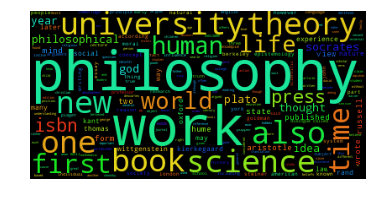

In [14]:
# Read the whole text.
text = branch_text[1][1]

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud)
plt.axis("off")

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

TypeError: 'WordCloud' object is not callable

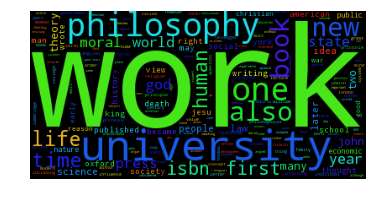

In [15]:
# Read the whole text.
text = branch_text[2][1]

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud)
plt.axis("off")

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

TypeError: 'WordCloud' object is not callable

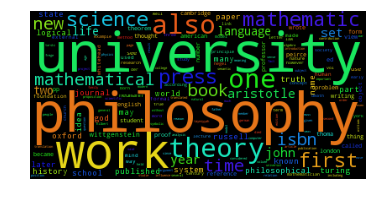

In [16]:
# Read the whole text.
text = branch_text[3][1]

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud)
plt.axis("off")

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

TypeError: 'WordCloud' object is not callable

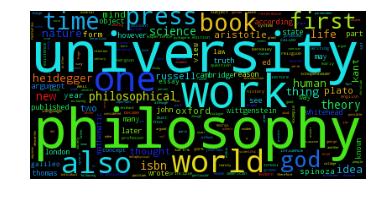

In [18]:
# Read the whole text.
text = branch_text[4][1]

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud)
plt.axis("off")

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

AttributeError: 'WordCloud' object has no attribute 'WordCloud'

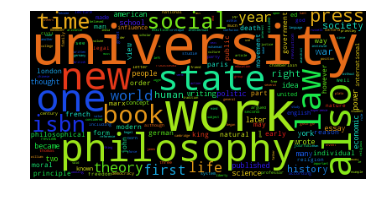

In [19]:
# Read the whole text.
text = branch_text[5][1]

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud)
plt.axis("off")

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Comment on wordcloud:

The wordclouds seem to reflect the branches as well as the TF-IDF scores does. Considering that we've simply repeated a word the number of times the TF-IDF score, this makes sense and we should not expect to read more out of it, though it does allow for more easily processing a larger amount of data and understanding the distributions of the data in a more readily available way.

# Part 2: Explicit Semantic Analysis and text relatedness

## 3A. Preparing the matrix. First, let's think about at the matrix we'll be creating.

* If the number of rows and columns of the matrix are the number of unique words and articles we've encountered, what will the dimensions og M be?
    
    * Answer: Given that we have 1069 articles there are 1069 categories and there are 1069 * 48876 =  dimensions
    
* By default, Python will store the TF-IDF scores as double-precision floats, meaning that each entry takes up 2 bytes on your disc. How much space will the full matrix take up?

    * Answer: Given the 5.2248.444 million dimensions it'll require 104,496,888 bytes or 99 MB to store.

* ESA is also done on Wikipedia in its entirety, which consists of 4.4 million articles and about 23 million words. What are the answers to the above questions for the full Wikipedia?
    
    * Answer: Dimension of entire wikipedia: 101.2 million
    * Answer: Storing with double precision floats: 222.6 million bytes or 192 MB
    
    
* Create a few small DOK-matrices and make sure that you know how to multiply them and how to find the indices of the maximum element of a matrix. Beware! when you multiply two DOK matrices, Python returns the result in CSR (compressed sparse row) format instead. This is a really nice format for matrices with sparse rows but it's a lot less intuitive, so you probably want to stick with the DOK format. You can convert between formats with e.g. mydokmatrix = somecsrmatrix.todok().

In [20]:
# Just playing around with it
dok_foo = dok_matrix(np.random.rand(20,2))
dok_bar = dok_matrix(np.random.randn(2,20))
csr_foobar = dok_foo.dot(dok_bar)
dok_foobar = csr_foobar.todok()

## 3B. Constructing the matrix

* For each philosopher, read in their wiki article and process the text, for instance by tokenizing, stemming, removing stop words etc. I got some pretty good results using the WordNetLemmatizer from NLTK. Remember to keep track of which tokens came from which article. A dictionary is a nice and fast way of doing this.


In [4]:
def createPhilDict():
    # Create the philosopher dict {phil: 'words': { [], 'ID': int}, 'word': int}
    stemmer = nltk.stem.porter.PorterStemmer()
    lem = nltk.WordNetLemmatizer()
    uniqPhilDict = defaultdict(lambda: defaultdict(int))
    articleID = 0

    for path, _, files in os.walk(os.getcwd() + '/data/phils/'):
        print path
        for i,fh in enumerate(files):
            if i < 5:
                if fh != 'all.txt' and fh[-5:] != '.json': # Ignore dumped files and the file containing all phil texts (in branch)
                    fp = io.open(path + '/' + fh, 'r', encoding = 'utf-8')
                    uniqPhilDict[fh]['words'] = []
                    uniqPhilDict[fh]['ID'] = articleID
                    cleaned = clean_sentences(fp.readlines())

                    for word in cleaned:

                        word = stemmer.stem(word)
                        word = lem.lemmatize(word)
                        uniqPhilDict[fh]['words'].append(word)
                        uniqPhilDict[fh][word] += 1
                        articleID += 1

    return uniqPhilDict
philDict = createPhilDict()

/Users/sarahmcgillion/socialgraphs/Projects/Assignment2/data/phils/
/Users/sarahmcgillion/socialgraphs/Projects/Assignment2/data/phils/aestheticians
/Users/sarahmcgillion/socialgraphs/Projects/Assignment2/data/phils/epistomologists
/Users/sarahmcgillion/socialgraphs/Projects/Assignment2/data/phils/ethicists
/Users/sarahmcgillion/socialgraphs/Projects/Assignment2/data/phils/logicians
/Users/sarahmcgillion/socialgraphs/Projects/Assignment2/data/phils/metaphysicians
/Users/sarahmcgillion/socialgraphs/Projects/Assignment2/data/phils/socio-political


In [6]:
def create_idfDict(countsDict):
    # Creates a dict for getting DF for each word
    idfDict = defaultdict(list)
    for article in countsDict.keys():
        for word in countsDict[article]['words']:
            if article not in idfDict[word]:
                idfDict[word].append(article)
    return idfDict

def cutOffWords(countsDict):
    # Let's just remove some words
    idfDict = create_idfDict(countsDict)
    for word in idfDict.keys():
        if len(idfDict[word]) < 3:
            idfDict[word] = []

    return idfDict

idfDict = create_idfDict(philDict) # we only use a small number of documents so we do no cut off

* Try plotting the different number of tokens you obtain from each article. It might make sense to introduce a cut-off and attempt to reduce noise by removing articles with too few tokens. For instance, mine looked like this



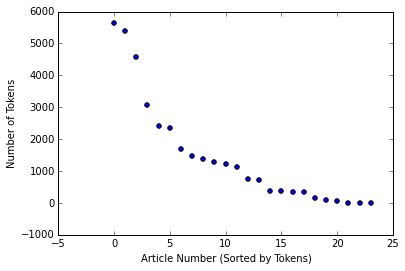

In [7]:
vals = []
for article in philDict.keys():
    vals.append((philDict[article]['ID'], len(philDict[article]['words']))) # List of (article, token) number tuples

vals = sorted(vals, key=lambda tup: tup[1])[::-1]
xvals = [i for i in range(len(vals))]
yvals = [vals[i][1] for i in range(len(vals))]
plt.scatter(xvals, yvals)
plt.ylabel('Number of Tokens')
plt.xlabel('Article Number (Sorted by Tokens)')

* Now it's time to find out how many unique words you have. You should be wary of words that are repeated a very large number of times in very few articles (why is this?), so don't include words which appear in very few articles (I chose 3 as a cutoff, but feel free to experiment.) Important: Do not use lists to store your uniques words as lists are extremely slow. Instead, you can use either use Python's set structure or use a dictionary in which the unique words are keys (in that case, you can use to check if the word is in your dict.)

* Answer 
    
    Articles with a large number of repeated tokens that are only apparent in very few documents will attain a very high TF-IDF as these terms will be very frequent for a small number of articles. However, this does not necessarily mean that they are relevent. For instance, if an internet troll decided to go on 2 wikipedia pages and replace all words with 'Troll', it would not make the topic of the page 'Troll' yet if only considering TF-IDF, we would be lead to believe that 'Troll' is a great way of distinguishing that article.

In [8]:
len(idfDict.keys()) # Corresponds to number of unique words since each word is a key

6218

* Create dictionaries mapping each unique word to a row index and each article to a column index and vice versa. You'll need these to determine, e.g. which row in your matrix a given word corresponds to.


In [94]:
mapDict = defaultdict(list) # {'articles': [], 'words': []}
mapDict['articles'] = [article for article in philDict]
mapDict['words'] = [word for word in idfDict]

phil2ind = {ph:j for ph,j in zip(mapDict['articles'],range(len(mapDict['articles'])))}
ind2phil = {j:ph for ph,j in zip(mapDict['articles'],range(len(mapDict['articles'])))}

ind2word = {i: word for word, i in zip(mapDict['words'], range(len(mapDict['words'])))}
word2ind = {word:i  for word, i in zip(mapDict['words'], range(len(mapDict['words'])))} # Create indices

* Create a DOK-matrix with dimensions based on the number of philosophers and unique words that you have now. For each article, compute the TF-IDF of its words and update the matrix. Use 1+log(count(word i, document j)) for term frequency if the count is non-zero, and TF = 0 otherwise. Hint: You can save a bit of time by first computing all of the IDF of each word and store them in a dictionary, so you don't have to repeat the same computations in each article. Normalise each row in the matrix. Such that the Pythagorean length of each row is 1.

In [11]:
d_matrix = dok_matrix((len(mapDict['words']),len(mapDict['articles'])))
n_docs = d_matrix.shape[1]
indDict = defaultdict(list)



for i, word in enumerate(mapDict['words']): # For every word and index
    for j, article in enumerate(philDict): # For every article and index
        if word in philDict[article]['words']: # If the word is in the article
            df = len(idfDict[word]) # Get the Document Frequency
            if df == 0: # If it's been cut off
                d_matrix[i, j] = 0.000001
            else: # Otherwise save the tf-idf
                tf  = philDict[article][word]
                d_matrix[i, j] = tf_idf_helper(tf, df, n_docs)
        col_id +=1
    
    norm = 1.0 / np.sqrt(sum(el**2 for el in d_matrix.getrow(i).toarray()))
    d_matrix[i,:] *= norm 

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:23: RuntimeWarning: divide by zero encountered in divide



* Again, you might want to introduce a cutoff for TF-IDFs below which you simply set the score to zero to avoid spurious associations. For instance, my TF-IDFs looked like this

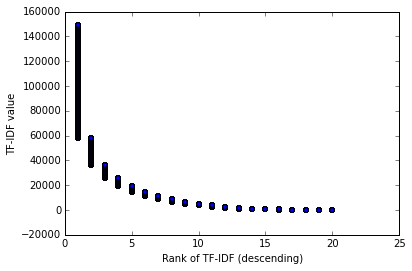

In [19]:
vals = []
xvals = sorted(d_matrix.values())[::-1]
yvals = [range(len(xvals))]
plt.scatter(xvals, yvals)
plt.ylabel('TF-IDF value')
plt.xlabel('Rank of TF-IDF (descending)')

## 4. Creating semantic vectors
* Consider for instance the word 'ontology' (feel free to use another). Which row in your matrix does the word correspond to?
* Instead of manually extracting rows from your matrix, you can convert each text to a row vector where each element is simply the number of occurrences of the corresponding word in the input text. For example, if the word 'ontology' has index 1337 in your matrix and occurs 3 times in your input text, the resulting row vector should have the value 3 at position 1337. Write a function to convert texts into row vectors in that way (remember to process the input text in the same way as earlier (stemming, tokenizing, etc.) and to take into account that the input text might contain words that you didn't encounter in the articles you've processed). Convince yourself that you can obtain the semantic vector corresponding to a text by converting it to a row vector in this way and then multiplying it with the matrix obtained earlier.
* Let's do a sanity check on this. Find a text relating to a philosopher and convert it to a semantic vector using the method you just wrote. (For instance, I went to Stanford Encyclopedia of Philosophy's page on Martin Heidegger and copied a section of text descriping Heidegger's phenomenology.) Find the 10 largest elements of your semantic vector. Is the element at the index corresponding to Heidegger largest?


In [34]:
def get_sem_vect(docstring, n_words=len(mapDict['words'])):

    # Clean words
    vect = np.zeros((n_words))
    cleaned = clean_sentences(docstring)
    stemmer = nltk.stem.porter.PorterStemmer()
    lem = nltk.WordNetLemmatizer()
    
    for word in cleaned:
        word = stemmer.stem(word)
        word = lem.lemmatize(word)
        if word in word2ind.keys():
            idx = word2ind[word] # Get index of word
            vect[idx] += 1 # Update count
    return vect

In [31]:
smith = """In any case, Smith concluded his lectures on jurisprudence with some extended remarks on “police”—public policy —and this he did, of course, work up into a book of its own. It is unclear, however, how much WN has to do with his philosophical concerns. Smith became increasingly interested in political economy after completing TMS, and WN can be seen as the fruition simply of a new direction in his research, unconnected to his moral system. He did come to a comprehensive, one might say philosophical, view of political economy: from his understanding of the workings of economics, he thought that states could foster the productiveness of their economies only by the rule of law, accompanied by a few limitations on banking practices, and should otherwise lift measures that restrict or encourage particular enterprises. The practical point of his treatise on economics was to urge this restrained, modest approach to economic intervention on governing officials. Smith did not favor as hands-off an approach as some of his self-proclaimed followers do today—he believed that states could and should re-distribute wealth to some degree, and defend the poor and disadvantaged against those who wield power over them in the private sector (see Fleischacker 2004, § 57)—but he certainly wanted the state to end all policies, common in his mercantilist day, designed to favor industry over agriculture, or some industries over others. Smith believed strongly in the importance of local knowledge to economic decision-making, and consequently thought that business should be left to businesspeople, who understand the particular situations in which they work far better than any government official (on this Hayek understood Smith well: see Hayek 1978 and C. Smith 2013). By the same token, governance should be kept out of the hands of businesspeople, since they are likely to use it to promote their particular interests, and not be concerned for the well-being of the citizenry as a whole: Smith's opposition to the East India Company is based on this principle (see Muthu 2008).Smith's political views tend more generally towards a minimalist state. He did not want the state to micro-manage the economy, and he also did not want it to promote religion or virtue. He was suspicious of the motives and skills of politicians, and their ability, even when well-meaning, to change society (see Fleischacker 2004, chapter 11). And he did not believe that the political life was the crown of the moral life, or that law or political institutions can help people develop virtue."""
res_vect = get_sem_vect(smith)

idx = phil2ind['Adam_Smith'] 
print idx
col = d_matrix.getcol(idx)
largest_idx_vect = np.argsort(res_vect)
col_largest_idx = np.argsort(np.array(col.todense()).flatten())

print "new text\t from M\n"

for i in range(10):
    print ind2word[largest_idx_vect[i]] + '\t\t\t' + ind2word[col_largest_idx[i]]



21
new text	 from M

four			profit
expert			sikh
reserv			solitari
tender			thirti
demythifi			launch
gravest			gilbert
lion			precari
ousia			cranli
satiris			hierarchi
bannerman			isl


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


As we see the words are different thus the two are not similar. We accept this is potentailly due to the decision to use only a few articles from the corpus of philosopher texts and thus the values may differ from the answers if we had have used the entire corpus.


## 5. Recommendations

* First, get a hold of a few philosophical texts. For example, you can find a collection of short philosophical texts here, but feel free to find some yourself. In case you're lazy, you can download ten essays that I randomly chose here.
* Write a method which takes as its input 2 texts and returns their cosine similarity. You can obtain the dot product between two vectors with dot = vectora.dot(vectorb.transpose()). For some reason Scipy insists on returning this as a (1x1) sparse matrix in another format than DOK, which you're used to by now. You can extract the actual value with val = dot.data[0].
* Finally, write a method which accepts a text as its argument and returns the title of the philosophical essay which has the largest cosine similarity with that text.

### Try out your recommender system

* Try finding a snippet of philosophy-related text that you find interesting. Which essay does your program recommend you based on that? Did you find that interesting as well?
* Try converting an essay from a specific topic to a semantic vector. Which philosophers account for the largest elements in the semantic vector? Are they from the same branch as the essay you selected?

In [62]:
def two_texts(first, second):
    # Get sem vectors for both and then get the dot product 
    sem_first = get_sem_vect(first).reshape(1,-1) 
    sem_second = get_sem_vect(second).reshape(-1,1)
    
    # Returns the cos similarity
    return np.dot(sem_first,sem_second)/np.linalg.norm(sem_first)/np.linalg.norm(sem_second) 

def get_title(first):
    path = os.getcwd() + '/data/texts'
    cos = []
    max_cos = np.NINF # So we have a starting value of -infinity
    for _, _, files in os.walk(path):
        for fh in files:
            fp = io.open(path + '/' + fh).read()
            cos = two_texts(fp, first)
            if cos > max_cos and first != fp: # Make sure that the two documents aren't the same
                max_cos = cos
                most_similar = fh # Get the most similar file name (text title name)
                
    return most_similar 



In [63]:
## We are using the text from above on Smith's political views.
## We are comparing these that were given links to in the assignment description
get_title(smith)

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


'Applied ethics.txt'

We see that the most similar article is one on applied ethics. This is a fair recommendation as the Adam Smith text we use is a piece based on his political views which is very related to the field of ethics. In wikipedia Adam Smith is listed under ethicists.

In [69]:
## Make a matrix of occurences

count_matrix = dok_matrix((len(mapDict['words']),len(mapDict['articles'])))
n_docs = count_matrix.shape[1]
indDict = defaultdict(list)



for i, word in enumerate(mapDict['words']): # For every word and index
    for j, article in enumerate(philDict): # For every article and index
        if word in philDict[article]['words']: # If the word is in the article
            tf  = philDict[article][word]
            if tf == 0: # If it's not in this doc
                count_matrix[i, j] = 0
            else: # Otherwise save the tf
                
                count_matrix[i, j] = tf


In [97]:
# Convert one of the essays to a semantic vector, then find out which phils are


def similar_phils(first,M,topN=10):
    
    sem_first = get_sem_vect(first).reshape(1,-1)
    
    cos = []
    for i in range(M.shape[1]): # Loop through the columns
        
        sem_second = np.array(M.getcol(i).todense()).flatten().reshape(-1,1)
        
        
        cos_sim = np.dot(sem_first,sem_second)/np.linalg.norm(sem_first)/np.linalg.norm(sem_second) 
        #print i, cos_sim[0][0]
        cos.append((i,cos_sim[0][0]))  # append the cosine similarity and the index
    
    cos = sorted(cos,key=lambda x: x[1])[::-1] # Sort by the cosine similarity
    
    top_phils = [ind2phil[idx] for idx,_ in cos[:topN] ] # Get the topN philosophers
    return top_phils






In [98]:
art_article = os.getcwd() + '/data/texts+/Definitions of art.txt'
print similar_phils(art_article,count_matrix,topN=2)

['Adrian_Johnston_(philosopher)', 'Adam_Smith']


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: RuntimeWarning: invalid value encountered in divide


## 6. Machine learning and text classification

* First, create a feature vector x for each article. A feature vector is just a list of numbers where each element denotes the number of occurrences of a word in the text. You can do this by first obtaining all the unique words encountered in the training set and then making a dictionary which maps an index to each of the words. Then you can construct each feature vector by first making a list of zeroes, then iterating through the words in your text and using the dictionary you just made to increment the correct element each time you encounter a word.

* Then, create a label y for each article (simply use a unique integer to denote each branch)

* Split your wikipedia articles into a training and a testing set. Typically, one uses 80% of the data to train on, but feel free to try varying this.

* Finally, set up a Multinomial Naive Bayesian classifier and fit it to your training data with yourclassifiername.fit(X_train, Y_train). You can then check which fraction of the texts in your test set the classifier gets right with yourclassifiername.score(X_test, Y_test)

* Write another classifier which doesn't use simple vectors of word counts but instead uses the semantic vectors you computed earlier. Did you see an improvement?

In [136]:
def make_X_y(count_matrix,int2phil,phil2branch):
    
    X = count_matrix.copy().T # was words,phils want phils,words
    y = []
    
    for i in range(X.shape[0]):
        yes = False
        # i is the phil index
        phil_name = int2phil[i].replace('_', ' ')
        this_branch = phil2branch[phil_name]
        y.append(this_branch)
        
        
    
    
    return X, np.array(y)

def classify_me_NB(X,y):
    # 1: Label Encoder to change y to number
    le = LabelEncoder()
    ys = le.fit_transform(y)
    
    # Use NB multinomial
    clf = MultinomialNB()
    
    # Use train_test_split to get 80/20 split
    X_train, X_test, y_train, y_test = train_test_split(X, ys, test_size=0.20)
    
    # fit the classifier
    clf.fit(X_train,y_train)
    
    # predict on unseen test data
    pred = clf.predict(X_test)
    
    # Get the fraction correct: i.e. accuracy score
    acc = accuracy_score(y_test, pred)
    
    return acc

In [137]:
### A dictionary with philosophers as keys and their branch as values.
phil2branch = defaultdict(list)
for branch in branches:
    path = os.listdir(os.getcwd() + '/data/phils/' + branch)
    for it in path:
        phil2branch[it] = branch

In [139]:
X,y = make_X_y(count_matrix.tocsr(),ind2phil,phil2branch)
print 'BoW accuracy: ',(classify_me_NB(X,y))



BoW accuracy:  0.8


In [140]:
# 4: create ANOTHER FUCKING MASSIVE MATRIX, this time only
#    use the words that happen to be in the utterly random M matrix

# do 1 -3 again, for some reason, compare some numbers, none of which are
# relevant to anything in this assignment, holy shit what a mess.

## 7. Thinking about evaluation (the stuff in Chapter 6.3)

* This assignment is getting long, so we're not going to ask you to do any more actual coding. But in this exercise, I'd like you to think a little bit about evaluation (e.g. the metrics we discussed earlier: cross-validation, dev set, accuracy, precision and recall, confusion matrices, etc). In the exercise above, we ask you to report which fraction your classifier gets right/wrong. But what if you had time to use more of the tools for better understanding your results? Write a few paragraphs about how you would use those tools to analyze and improve the output from the Bayes Classifier.

First of all we would use 1 set hold out cross-validation on a dev set to train a more robust model. Furthermore we'd reduce the dimensionality by using Principle Component Analysis. we would also drop all notion of using simply accuracies to indicate how well the model does but instead use either a F1 score or specificity to determine the error rate of the model. I would also try to use not just a bag of words, but bigrams (as trigrams appear to harm performance).

We would use more libraries as they are blindingly fast compared to this. Furthermore we would actually use the TF-IDF as features as well.